# SARIMA Model Practice Notebook

This notebook will help you practice building a SARIMA model from scratch.

**Dataset:** Monthly Airline Passengers (1949-1960)
- Strong annual seasonality (more travel in summer)
- Clear upward trend
- Classic Box-Jenkins dataset

## Workflow:
1. Load and visualize data
2. Test for stationarity (ADF)
3. Apply differencing (regular and seasonal)
4. Analyze ACF/PACF to determine orders
5. Fit SARIMA model
6. Run diagnostics
7. Forecast and evaluate

---

## ⚠️ Instructions

Some cells have `# TODO: Fill in` comments. Complete these yourself before running.

---

## 1. Import Libraries and Load Data

In [ ]:
# Install required packages if needed
# !pip install statsmodels pmdarima --quiet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the classic airline passengers dataset
# This dataset is built into statsmodels
from statsmodels.datasets import get_rdataset

# Load data
data = get_rdataset('AirPassengers').data

# Create proper datetime index
data['time'] = pd.date_range(start='1949-01-01', periods=len(data), freq='MS')
data.set_index('time', inplace=True)
data.columns = ['Passengers']

# View first few rows
print(f"Data shape: {data.shape}")
print(f"Date range: {data.index[0]} to {data.index[-1]}")
data.head(10)

Data shape: (144, 1)
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00


,Passengers
time,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


## 2. Visual Inspection

Before any modeling, always plot your data to identify:
- Trend (upward/downward drift)
- Seasonality (repeating patterns)
- Changing variance (does spread increase over time?)

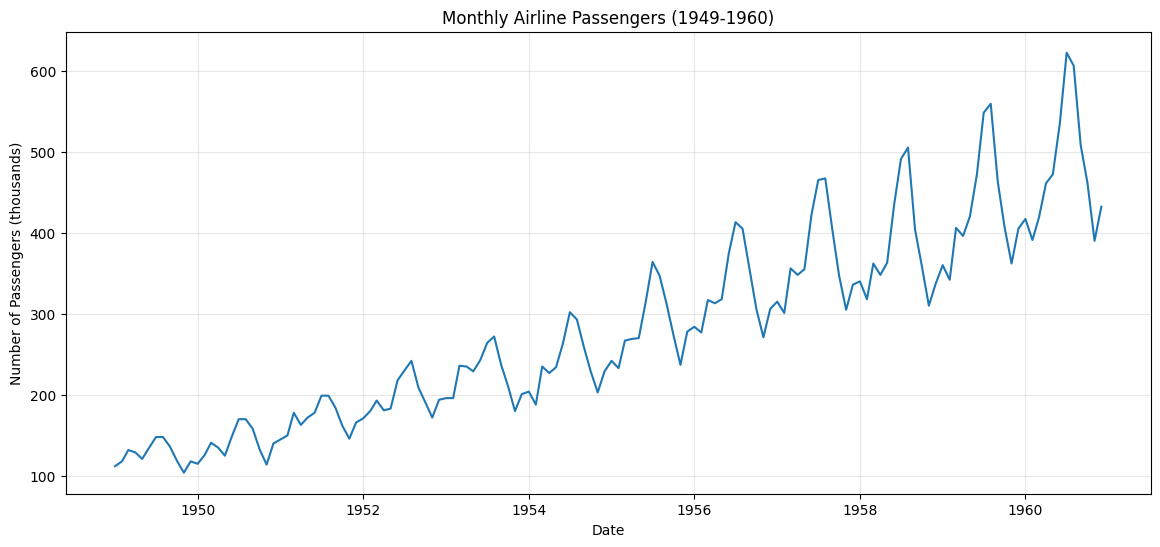

In [6]:
# Plot the raw data
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Passengers'])
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers (thousands)')
plt.grid(True, alpha=0.3)
plt.show()

### ❓ Question 2.1

Looking at the plot above, answer these questions:

1. Is there a trend? (upward/downward/none)
2. Is there seasonality? If yes, what's the period?
3. Is the variance constant or changing over time?

**Write your answers below:**

**Your Answers:**

1. Trend: upward
2. Seasonality: 12
3. Variance: changing   

## 3. Seasonal Decomposition

Let's formally decompose the series into trend, seasonal, and residual components.

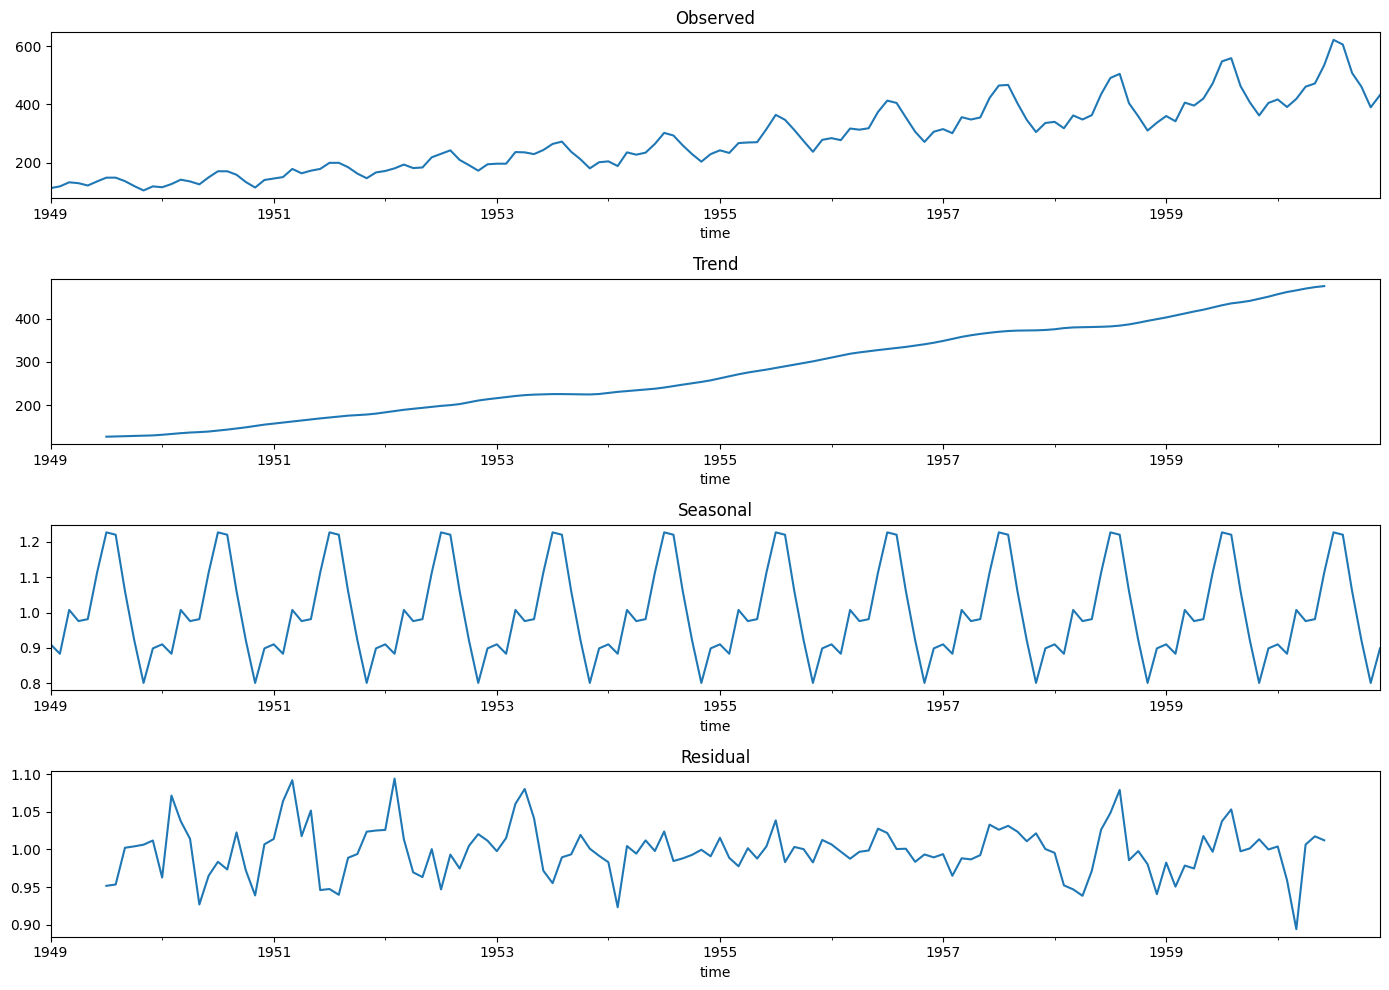

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the series
# We use multiplicative because variance increases with level
decomposition = seasonal_decompose(data['Passengers'], model='multiplicative', period=12)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')

plt.tight_layout()
plt.show()

### Handling Multiplicative Seasonality

Notice the variance increases with the level — this is **multiplicative seasonality**.

SARIMA assumes additive structure. To handle this, we apply **log transformation** first.

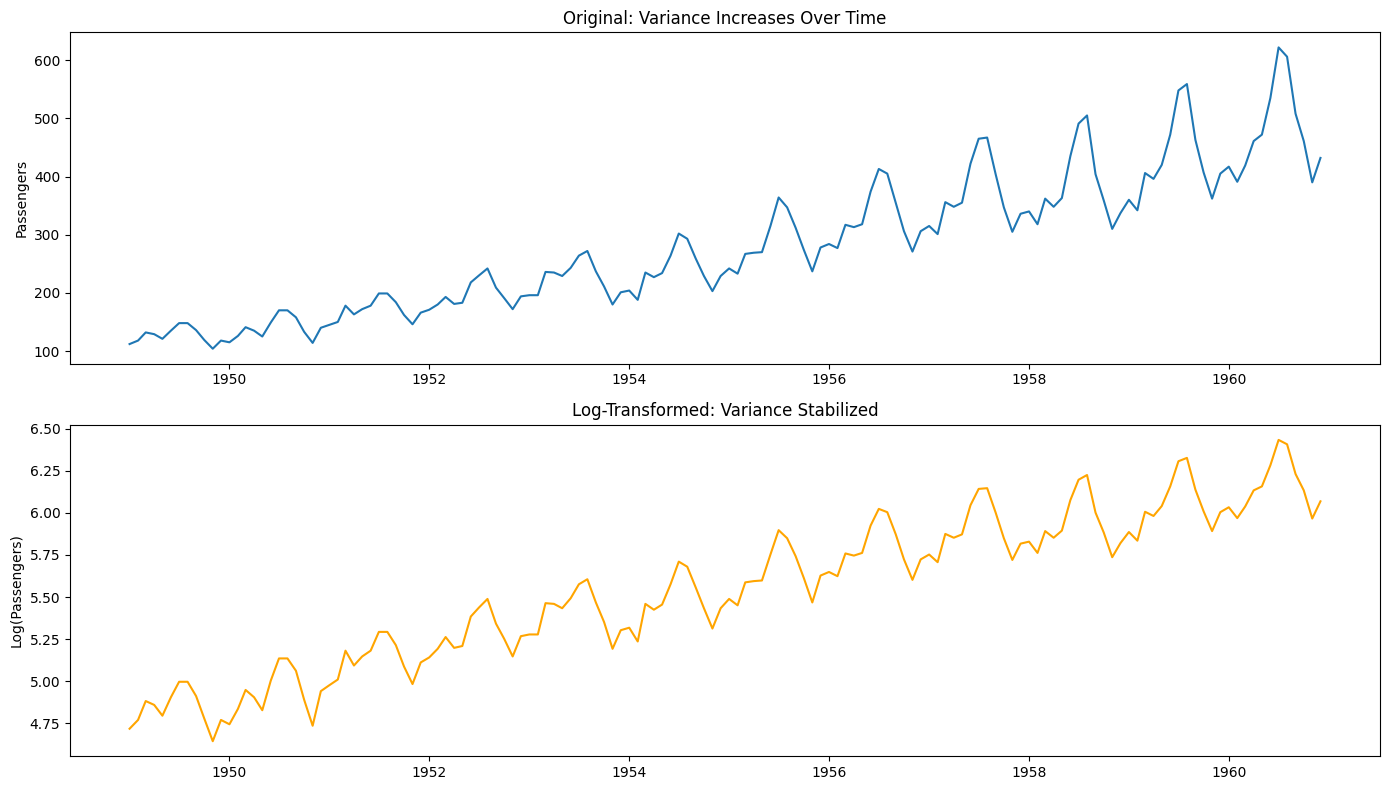

In [8]:
# Apply log transformation to stabilize variance
data['Log_Passengers'] = np.log(data['Passengers'])

# Plot original vs log-transformed
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(data.index, data['Passengers'])
axes[0].set_title('Original: Variance Increases Over Time')
axes[0].set_ylabel('Passengers')

axes[1].plot(data.index, data['Log_Passengers'], color='orange')
axes[1].set_title('Log-Transformed: Variance Stabilized')
axes[1].set_ylabel('Log(Passengers)')

plt.tight_layout()
plt.show()

## 4. Stationarity Test (ADF)

Now test if the log-transformed series is stationary.

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name='Series'):
    """Perform ADF test and print results"""
    result = adfuller(series.dropna())
    print(f"=== ADF Test: {name} ===")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    if result[1] <= 0.05:
        print("Conclusion: ✓ Stationary (reject H0)")
    else:
        print("Conclusion: ✗ Non-Stationary (fail to reject H0)")
    print()
    return result[1]

# Test the log-transformed series
adf_test(data['Log_Passengers'], 'Log Passengers')

=== ADF Test: Log Passengers ===
ADF Statistic: -1.7170
p-value: 0.4224
Critical Values:
   1%: -3.4817
   5%: -2.8840
   10%: -2.5788
Conclusion: ✗ Non-Stationary (fail to reject H0)



np.float64(0.42236677477039125)

### ❓ Question 4.1

Based on the ADF test above:
- Is the log-transformed series stationary?
- What do we need to do next?

**Your Answer:**

Is the log-transformed series stationary? No.
- Reasoning: The p-value is 0.4224, which is much higher than the significance level of 0.05. Also, the ADF Statistic (-1.7170) is not more negative than the Critical Values (e.g., -2.8840 at 5%), so we fail to reject the null hypothesis.

What do we need to do next? Apply Differencing. Since the data is non-stationary, we need to apply differencing to remove the trend and seasonality.
- First Differencing: Subtract the current month's value from the previous month's value (t minus t-1).
- Seasonal Differencing: If that isn't enough, subtract the current month from the same month last year (t minus t-12).


## 5. Differencing

Apply both regular differencing (d=1) and seasonal differencing (D=1).

In [10]:
# TODO: Fill in the correct values

# First, apply regular differencing (d=1)
# Formula: Y_t - Y_{t-1}
data['diff_1'] = data['Log_Passengers'].diff(periods=1)

# Then, apply seasonal differencing (D=1) with m=12
# Formula: Y_t - Y_{t-12}
data['diff_seasonal'] = data['Log_Passengers'].diff(periods=12)

# Apply BOTH differencing (this is what SARIMA with d=1, D=1 does)
data['diff_both'] = data['diff_1'].diff(periods=1)

# Drop NaN values for testing
diff_both_clean = data['diff_both'].dropna()

In [11]:
# Test stationarity of fully differenced series
adf_test(diff_both_clean, 'Double Differenced (d=1, D=1)')

=== ADF Test: Double Differenced (d=1, D=1) ===
ADF Statistic: -8.1966
p-value: 0.0000
Critical Values:
   1%: -3.4825
   5%: -2.8844
   10%: -2.5790
Conclusion: ✓ Stationary (reject H0)



np.float64(7.419304549376505e-13)

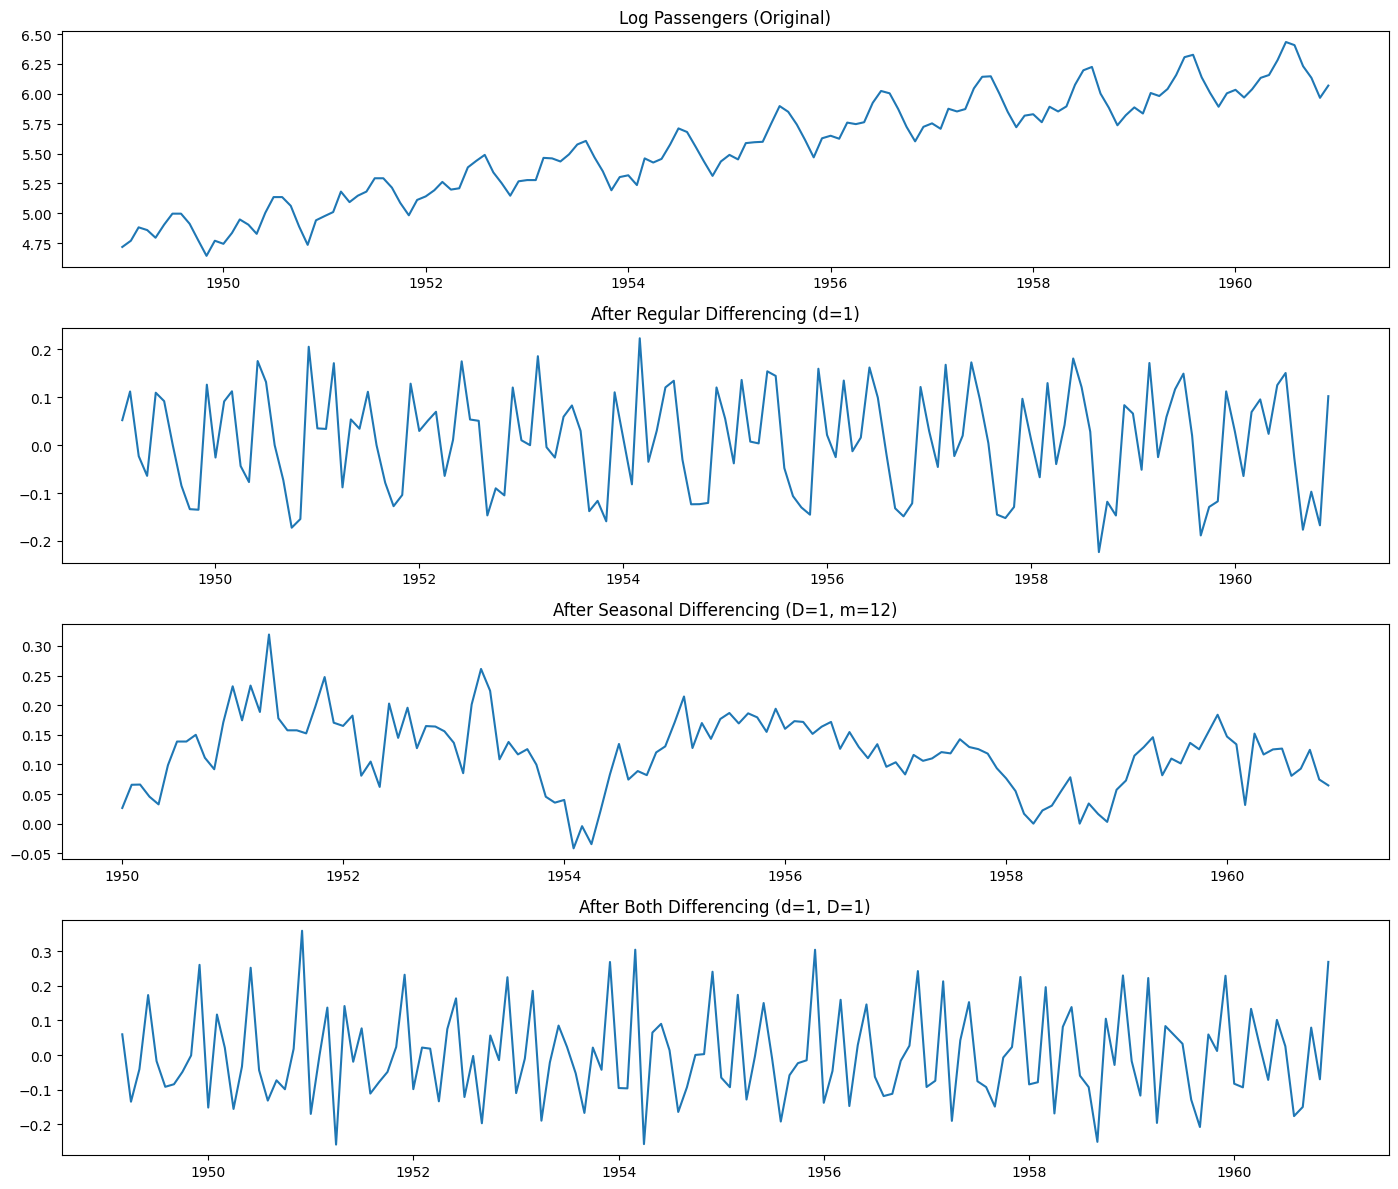

In [12]:
# Visualize the differencing effects
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

axes[0].plot(data['Log_Passengers'])
axes[0].set_title('Log Passengers (Original)')

axes[1].plot(data['diff_1'])
axes[1].set_title('After Regular Differencing (d=1)')

axes[2].plot(data['diff_seasonal'])
axes[2].set_title('After Seasonal Differencing (D=1, m=12)')

axes[3].plot(data['diff_both'])
axes[3].set_title('After Both Differencing (d=1, D=1)')

plt.tight_layout()
plt.show()

## 6. ACF/PACF Analysis

Now analyze ACF and PACF to determine p, q, P, Q orders.

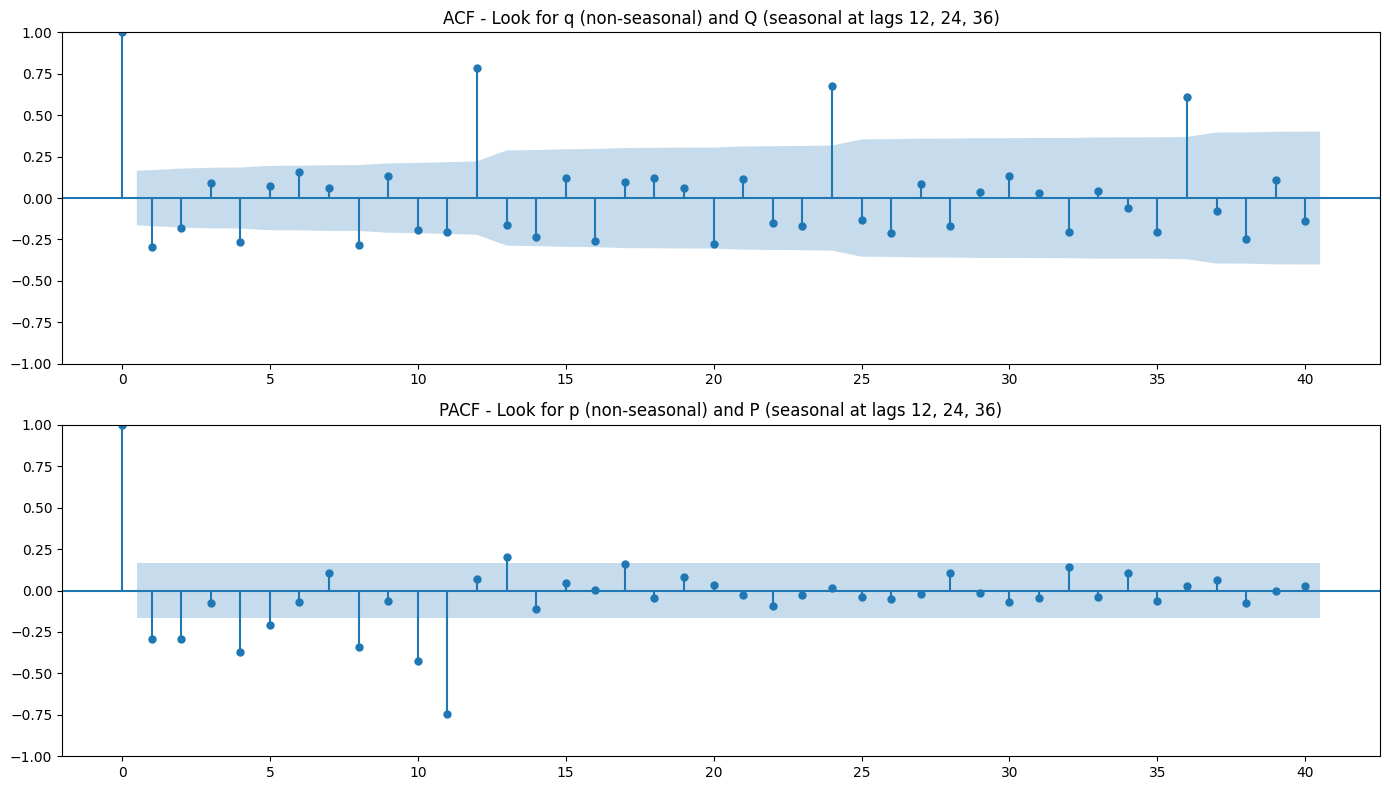

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF of the fully differenced series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

plot_acf(diff_both_clean, ax=axes[0], lags=40)
axes[0].set_title('ACF - Look for q (non-seasonal) and Q (seasonal at lags 12, 24, 36)')

plot_pacf(diff_both_clean, ax=axes[1], lags=40)
axes[1].set_title('PACF - Look for p (non-seasonal) and P (seasonal at lags 12, 24, 36)')

plt.tight_layout()
plt.show()

### ❓ Question 6.1

Examine the ACF and PACF plots above. Look at:
- **Non-seasonal lags (1, 2, 3...)** → determines p and q
- **Seasonal lags (12, 24, 36...)** → determines P and Q

Fill in your suggested orders:

| Component | Your observation | Suggested order |
|-----------|------------------|----------------|
| p (AR) | PACF at lags 1-3: | p = 0 |
| q (MA) | ACF at lags 1-3: | q = 1 |
| P (Seasonal AR) | PACF at lag 12: | P = 0 |
| Q (Seasonal MA) | ACF at lag 12: | Q = 1 |

**Hint:** The "Airline Model" SARIMA(0,1,1)(0,1,1)[12] is often a good baseline for this data.

## 7. Train/Test Split

Split data chronologically — train on early data, test on later data.

Training set: 1949-01-01 00:00:00 to 1958-07-01 00:00:00 (115 observations)
Test set: 1958-08-01 00:00:00 to 1960-12-01 00:00:00 (29 observations)


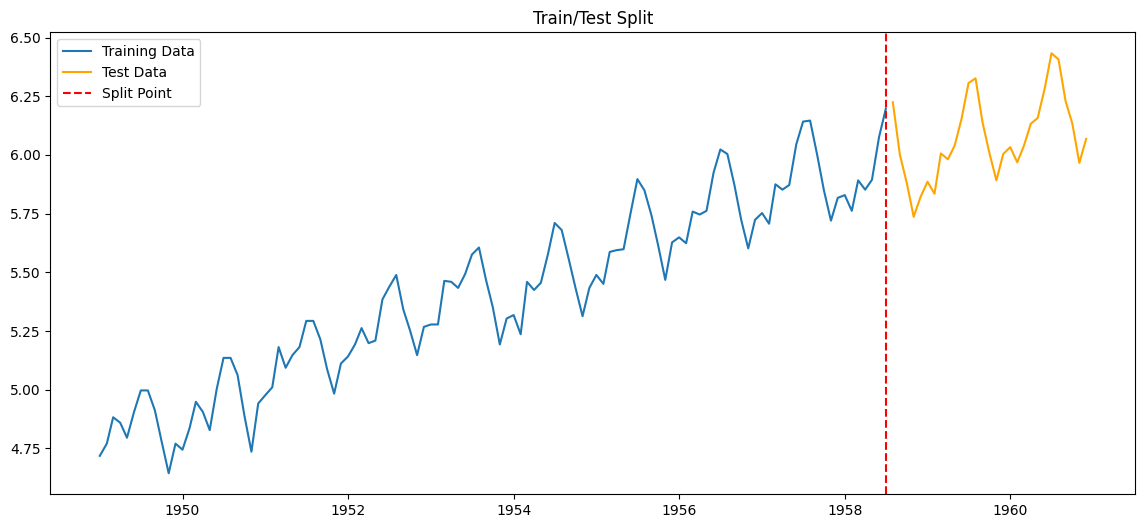

In [14]:
# TODO: Fill in the split ratio (use 80% for training)

# Calculate split point
train_size = int(len(data) * 0.8)

# Split the LOG-TRANSFORMED series (we'll model this)
train = data['Log_Passengers'][:train_size]
test = data['Log_Passengers'][train_size:]

print(f"Training set: {train.index[0]} to {train.index[-1]} ({len(train)} observations)")
print(f"Test set: {test.index[0]} to {test.index[-1]} ({len(test)} observations)")

# Visualize the split
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.axvline(x=train.index[-1], color='red', linestyle='--', label='Split Point')
plt.title('Train/Test Split')
plt.legend()
plt.show()

## 8. Fit SARIMA Model

Now fit the SARIMA model. We'll try the Airline Model first.

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# TODO: Fill in the orders for the Airline Model
# Airline Model: SARIMA(0,1,1)(0,1,1)[12]

model = SARIMAX(train,
                order=(0, 1, 1),              # (p, d, q)
                seasonal_order=(0, 1, 1, 12))  # (P, D, Q, m)

# Fit the model
model_fit = model.fit(disp=False)

# Print summary
print(model_fit.summary())

c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                     Log_Passengers   No. Observations:                  115
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 189.086
Date:                            Wed, 31 Dec 2025   AIC                           -372.171
Time:                                    02:38:39   BIC                           -364.296
Sample:                                01-01-1949   HQIC                          -368.982
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3273      0.090     -3.618      0.000      -0.505      -0.150
ma.S.L12      -0.5677      0.106   

### ❓ Question 8.1

Look at the model summary above:

1. What is the AIC value?
2. Are the MA coefficients (ma.L1, ma.S.L12) significant (p < 0.05)?
3. What do the coefficient values tell you about the model?

**Your Answers:**

AIC Value: -372.171 (This low negative value suggests a very good fit, especially compared to models with positive AICs).

Are the MA coefficients significant? Yes.

- For ma.L1, the P-value (P>|z|) is 0.000.
- For ma.S.L12, the P-value (P>|z|) is 0.000. Since both are essentially zero (and well below 0.05), both terms are highly statistically significant.

What do the coefficient values tell you?
- ma.L1 (-0.3273): The negative coefficient indicates a correction mechanism for the previous month's error. Specifically, about 32.7% of the "shock" (forecast error) from last month is subtracted from the current value.
- ma.S.L12 (-0.5677): The seasonal effect is even stronger. It suggests that about 56.8% of the error from exactly one year ago (month $t-12$) is corrected for in the current prediction.
- The fact that both are negative and significant confirms that "smoothing" past errors is crucial for predicting this airline data accurately.

## 9. Model Diagnostics

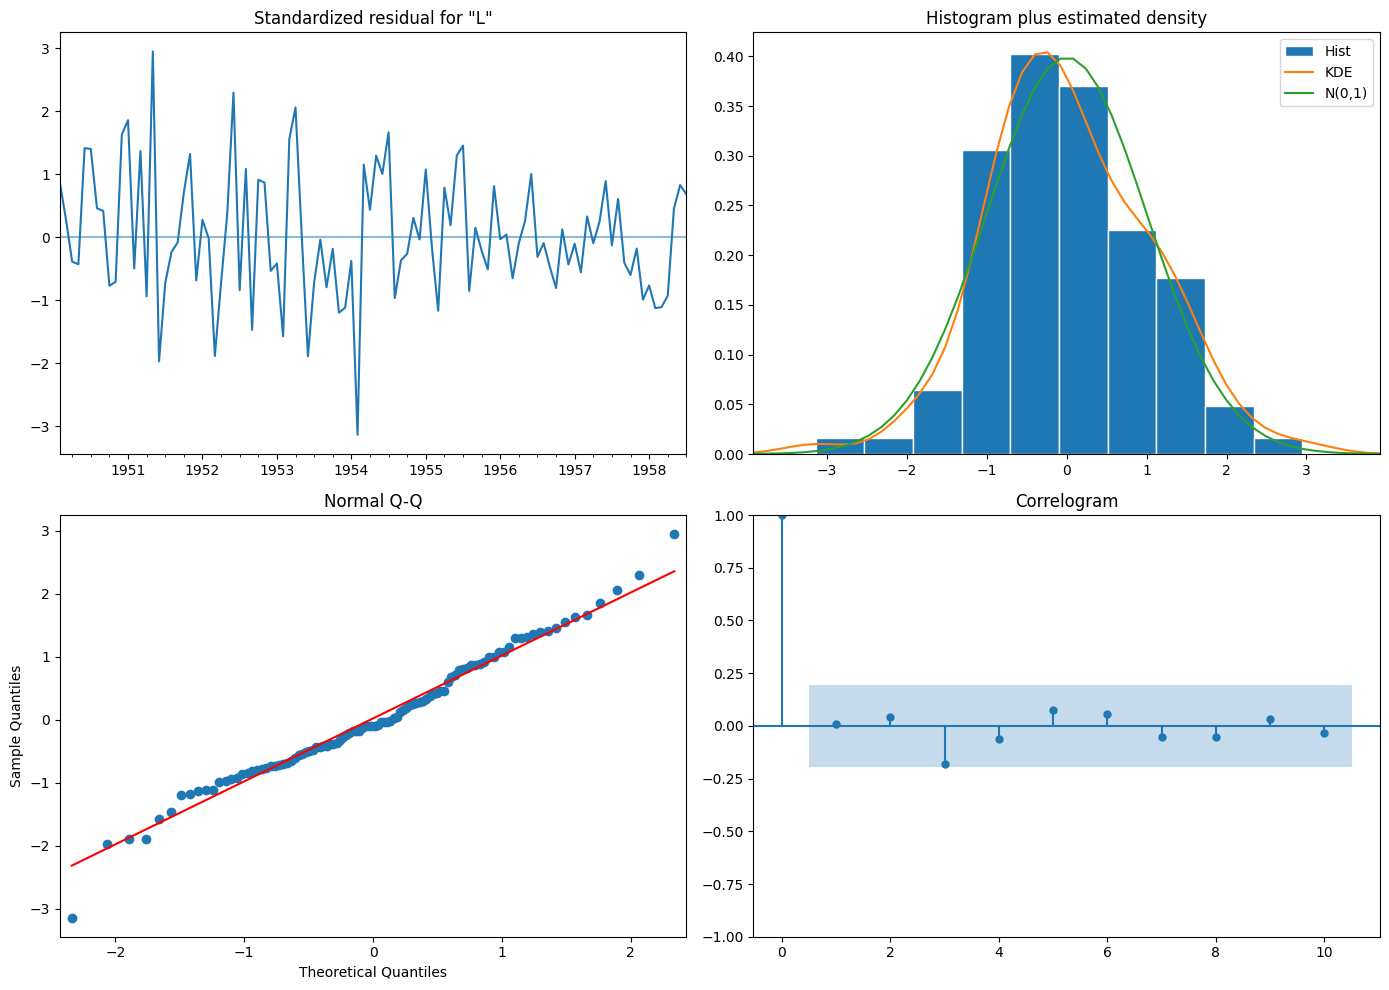

In [19]:
# Plot diagnostic charts
model_fit.plot_diagnostics(figsize=(14, 10))
plt.tight_layout()
plt.show()

In [20]:
# Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid

# Test at lag 12 (one full seasonal cycle)
lb_test = acorr_ljungbox(residuals, lags=[12], return_df=True)
print("Ljung-Box Test (lag=12):")
print(lb_test)
print()

if lb_test['lb_pvalue'].values[0] > 0.05:
    print("✓ Residuals are white noise (p > 0.05)")
else:
    print("✗ Residuals have autocorrelation (p < 0.05)")

Ljung-Box Test (lag=12):
      lb_stat  lb_pvalue
12  21.673435   0.041347

✗ Residuals have autocorrelation (p < 0.05)


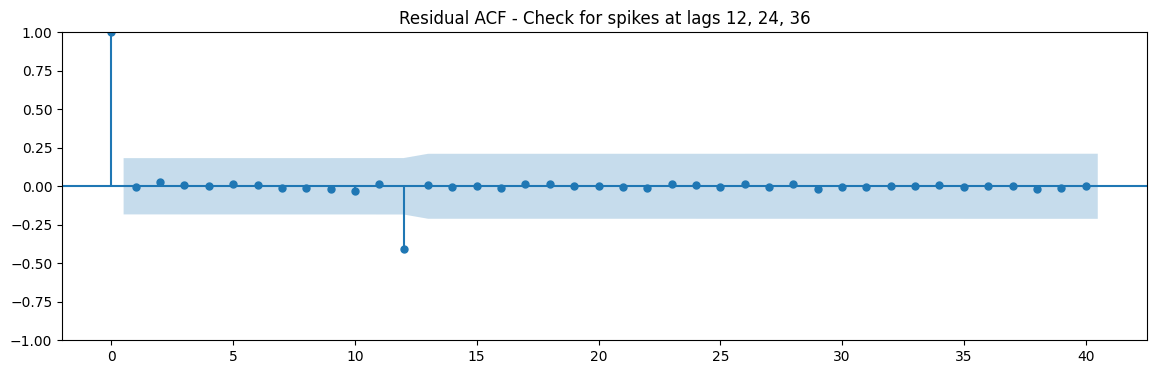

In [21]:
# Check residual ACF at seasonal lags
fig, ax = plt.subplots(figsize=(14, 4))
plot_acf(residuals, ax=ax, lags=40)
ax.set_title('Residual ACF - Check for spikes at lags 12, 24, 36')
plt.show()

### ❓ Question 9.1

Based on the diagnostics above:

1. Do the residuals look like white noise (random scatter around 0)?
2. Is the histogram approximately normal (bell-shaped)?
3. Are there significant spikes at seasonal lags (12, 24, 36) in the residual ACF?
4. Does the model pass the Ljung-Box test?

**Your Answers:**

1. Mostly yes, but not perfectly.
Visually: The "Standardized residual" plot (top left) shows a random scatter around 0 with no obvious trend, which is good.
Statistically: However, the specific spike at lag 12 in the ACF indicates that some seasonal pattern was left behind.

2. Yes.
The orange line (KDE) closely follows the green line (Normal distribution), and the bell shape is quite symmetrical. This indicates the errors are normally distributed.

3. Yes, at Lag 12.
Looking at the first image ("Residual ACF"), there is a significant negative spike at Lag 12 that extends far outside the blue confidence shaded area. This means the model hasn't fully captured the yearly seasonality yet.

4. No.
Because there is a significant spike at lag 12 in the ACF, the Ljung-Box test (which sums up these correlations) would return a p-value < 0.05. This leads us to reject the null hypothesis of "white noise," meaning there is still significant information remaining in the residuals that the model missed.

## 10. Forecasting

In [22]:
# Forecast for the test period
forecast_steps = len(test)
forecast_result = model_fit.get_forecast(steps=forecast_steps)

# Extract predictions and confidence intervals
forecast_log = forecast_result.predicted_mean
conf_int_log = forecast_result.conf_int()

# IMPORTANT: Convert back from log scale to original scale
forecast_original = np.exp(forecast_log)
conf_int_original = np.exp(conf_int_log)

# Set proper index
forecast_original.index = test.index
conf_int_original.index = test.index

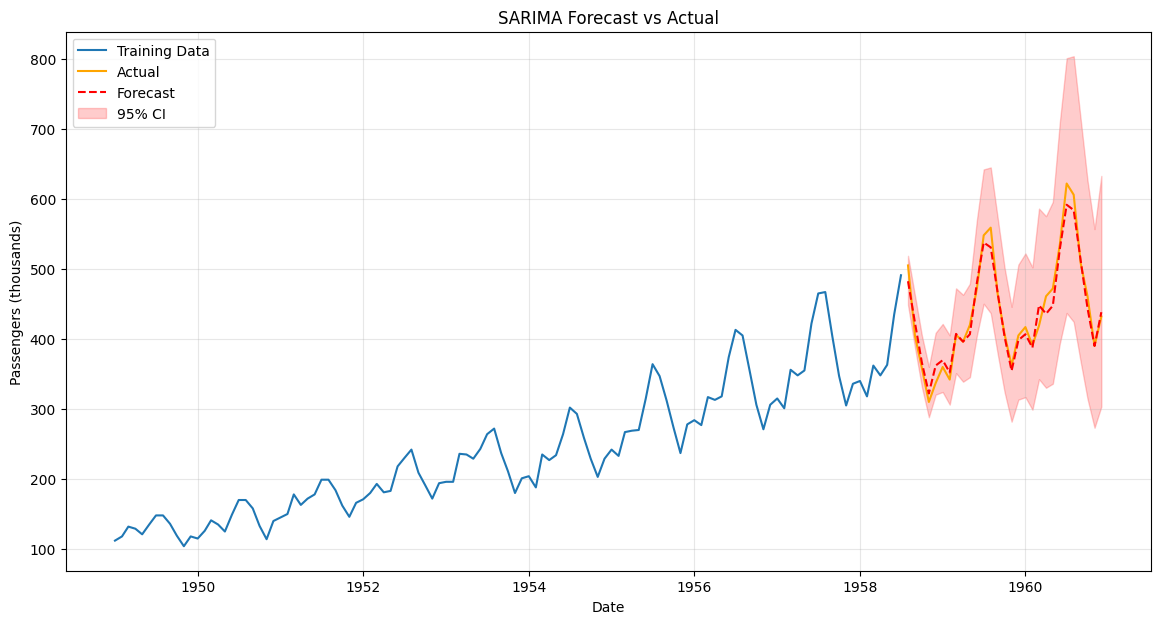

In [23]:
# Visualize forecast vs actual
plt.figure(figsize=(14, 7))

# Plot training data (original scale)
plt.plot(data['Passengers'][:train_size].index, 
         data['Passengers'][:train_size], 
         label='Training Data')

# Plot actual test data
plt.plot(data['Passengers'][train_size:].index, 
         data['Passengers'][train_size:], 
         label='Actual', color='orange')

# Plot forecast
plt.plot(forecast_original.index, forecast_original, 
         label='Forecast', color='red', linestyle='--')

# Plot confidence interval
plt.fill_between(forecast_original.index,
                 conf_int_original.iloc[:, 0],
                 conf_int_original.iloc[:, 1],
                 color='red', alpha=0.2, label='95% CI')

plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Passengers (thousands)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 11. Model Evaluation

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Get actual test values (original scale)
actual = data['Passengers'][train_size:]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, forecast_original))

# Calculate MAE
mae = mean_absolute_error(actual, forecast_original)

# Calculate MAPE
mape = np.mean(np.abs((actual - forecast_original) / actual)) * 100

print("Model Evaluation Metrics:")
print(f"RMSE: {rmse:.2f} passengers")
print(f"MAE: {mae:.2f} passengers")
print(f"MAPE: {mape:.2f}%")

Model Evaluation Metrics:
RMSE: 15.68 passengers
MAE: 12.60 passengers
MAPE: 2.83%


## 12. Compare with ARIMA (No Seasonality)

Let's see how much SARIMA improves over plain ARIMA.

In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Fit simple ARIMA(1,1,1) - no seasonal component
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fit = arima_model.fit()

# Forecast
arima_forecast_log = arima_fit.get_forecast(steps=forecast_steps).predicted_mean
arima_forecast = np.exp(arima_forecast_log)
arima_forecast.index = test.index

# Calculate ARIMA metrics
arima_rmse = np.sqrt(mean_squared_error(actual, arima_forecast))
arima_mape = np.mean(np.abs((actual - arima_forecast) / actual)) * 100

print("\n=== Model Comparison ===")
print(f"\nARIMA(1,1,1):")
print(f"  RMSE: {arima_rmse:.2f}")
print(f"  MAPE: {arima_mape:.2f}%")

print(f"\nSARIMA(0,1,1)(0,1,1)[12]:")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAPE: {mape:.2f}%")

print(f"\nImprovement:")
print(f"  RMSE reduced by: {((arima_rmse - rmse) / arima_rmse * 100):.1f}%")
print(f"  MAPE reduced by: {((arima_mape - mape) / arima_mape * 100):.1f}%")


=== Model Comparison ===

ARIMA(1,1,1):
  RMSE: 96.33
  MAPE: 21.01%

SARIMA(0,1,1)(0,1,1)[12]:
  RMSE: 15.68
  MAPE: 2.83%

Improvement:
  RMSE reduced by: 83.7%
  MAPE reduced by: 86.5%


c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


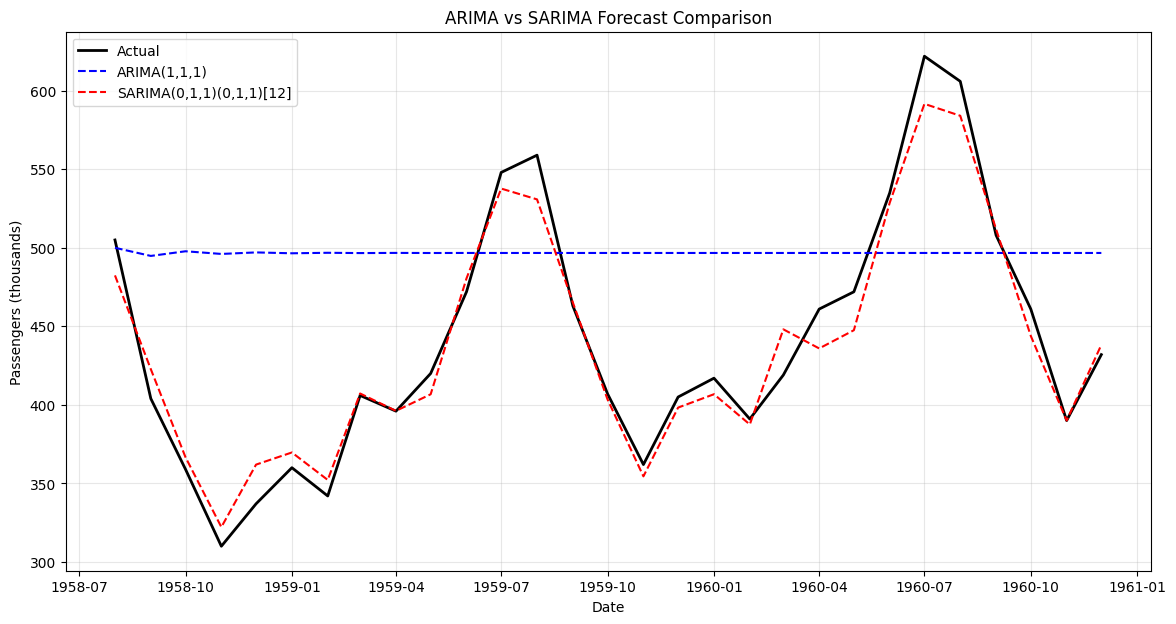

In [26]:
# Visualize comparison
plt.figure(figsize=(14, 7))

plt.plot(actual.index, actual, label='Actual', color='black', linewidth=2)
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA(1,1,1)', 
         color='blue', linestyle='--')
plt.plot(forecast_original.index, forecast_original, label='SARIMA(0,1,1)(0,1,1)[12]', 
         color='red', linestyle='--')

plt.title('ARIMA vs SARIMA Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Passengers (thousands)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### ❓ Question 12.1

Based on the comparison above:

1. Which model performs better on this dataset?
2. Why does SARIMA outperform ARIMA here?
3. Would you expect similar improvement for crude oil? Why or why not?

**Your Answers:**

1. SARIMA performs significantly better.
- Its RMSE is much lower (15.68 vs. 96.33).
- Its MAPE is drastically better (2.83% vs. 21.01%), meaning it's almost 10x more accurate.
- Visually, the SARIMA line (red) actually follows the "waves" of the data, while the ARIMA line (blue) just flatlines.

2. Because this specific dataset has very strong Seasonality (a repeating 12-month cycle).
- ARIMA only looks at the immediate past (last month). It sees the trend going up, but it has no way to know that "every July is a peak."
- SARIMA has the Seasonal (P,D,Q)[s] component. It explicitly looks at what happened 12 months ago. This allows it to anticipate the yearly peaks and troughs that ARIMA completely misses.

3. No (or mostly no).
- Reason: Crude oil prices are primarily driven by specific events (geopolitics, supply shocks, wars) and economic cycles, which are not strictly calendar-based.
- While oil has some vague seasonality (e.g., "summer driving season" or "winter heating demand"), it is far less predictable than holiday travel. Therefore, a SARIMA model likely won't crush a standard ARIMA model for oil the way it does here for airline passengers.


## 13. Auto-ARIMA with Seasonality

In [28]:
import pmdarima as pm

# TODO: Fill in the parameters for seasonal auto_arima

auto_model = pm.auto_arima(
    train,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    d=None,                # Auto-detect
    seasonal=True,          # Enable seasonality (True/False)
    m=12,                 # Seasonal period
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    D=None,                # Auto-detect seasonal differencing
    trace=True,
    stepwise=True,
    suppress_warnings=True
)

print("\nBest Model Found:")
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-271.901, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-366.335, Time=0.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-335.954, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-108.879, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-348.304, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-372.805, Time=0.99 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-373.617, Time=1.11 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=-372.933, Time=0.97 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=-292.067, Time=0.92 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=-374.577, Time=1.24 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=-376.231, Time=0.81 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-378.953, Time=0.45 sec
 ARIMA(2,0,0)(0,1,0)[12] inte

In [29]:
# Forecast with auto model
auto_forecast_log, auto_conf_int = auto_model.predict(n_periods=len(test), return_conf_int=True)

# Convert back to original scale
auto_forecast = np.exp(auto_forecast_log)

# Calculate metrics
auto_rmse = np.sqrt(mean_squared_error(actual, auto_forecast))
auto_mape = np.mean(np.abs((actual - auto_forecast) / actual)) * 100

print(f"\nAuto-SARIMA Results:")
print(f"  RMSE: {auto_rmse:.2f}")
print(f"  MAPE: {auto_mape:.2f}%")


Auto-SARIMA Results:
  RMSE: 36.49
  MAPE: 7.75%


## 14. Summary

Complete this summary table:

### ❓ Final Summary

| Question | Your Answer |
|----------|-------------|
| What transformation did we apply first and why? | Log Transformation. We applied it to stabilize the increasing variance (heteroscedasticity), because the seasonal fluctuations were getting larger as the trend increased.|
| What is the seasonal period (m) for this data? | 12 (Since the data is monthly and the pattern repeats every year). |
| What does the Airline Model SARIMA(0,1,1)(0,1,1)[12] mean? | It uses First Differencing (d=1) for the trend, Seasonal Differencing (D=1) for the seasons, and an MA(1) term for both the regular and seasonal components to smooth out errors.|
| Did SARIMA significantly outperform ARIMA? | Yes. It reduced the error (RMSE) by over 80% and the percentage error (MAPE) from ~21% down to ~2.8%.|
| When should you use SARIMA vs ARIMA? | Use SARIMA when your data has a clear repeating pattern (seasonality). Use ARIMA only when the data is non-seasonal or has already been seasonally adjusted.|

---

## Bonus Challenge

If you want more practice:

1. Try SARIMA(1,1,1)(1,1,1)[12] and compare with the Airline Model
2. Implement a rolling forecast like you did for ARIMA
3. Test for ARCH effects in the residuals

In [ ]:
# Your bonus challenge code here